In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!ls /content/drive/MyDrive/Capstone2

CLIP_Model


In [26]:
import os
import PIL
import cv2
import uuid
import shutil
import random
import glob as gb
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from tqdm import tqdm  # Progress bar

In [3]:
calc_train = pd.read_csv('/content/drive/MyDrive/Capstone2/CLIP_Model/csv/calc_case_description_train_set.csv')
calc_test = pd.read_csv('/content/drive/MyDrive/Capstone2/CLIP_Model/csv/calc_case_description_test_set.csv')
mass_train = pd.read_csv('/content/drive/MyDrive/Capstone2/CLIP_Model/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv('/content/drive/MyDrive/Capstone2/CLIP_Model/csv/mass_case_description_test_set.csv')
dicom_df = pd.read_csv('/content/drive/MyDrive/Capstone2/CLIP_Model/csv/dicom_info.csv')

In [4]:
def replace_path(sample, old_path, new_path):
    return sample.replace(old_path, new_path, regex=True)

In [5]:
def plot_smaples(sample, row=15, col=15):
    plt.figure(figsize=(row, col))
    for i, file in enumerate(sample[0:5]):
        cropped_images_show = PIL.Image.open(file)
        gray_img= cropped_images_show.convert("L")
        plt.subplot(1,5,i+1)
        plt.imshow(gray_img, cmap='gray')
        plt.axis('off')
    plt.show()

In [6]:
cropped_images = dicom_df[dicom_df.SeriesDescription=="cropped images"].image_path
full_mammogram = dicom_df[dicom_df.SeriesDescription=="full mammogram images"].image_path
roi_mask = dicom_df[dicom_df.SeriesDescription=="ROI mask images"].image_path

In [7]:
# Replace the path for cropped_images to the correct directory.
correct_dir = "/content/drive/MyDrive/Capstone2/CLIP_Model/jpeg"
cropped_images = replace_path(cropped_images, "CBIS-DDSM/jpeg", correct_dir)
print('Cropped Images paths:')
print(cropped_images.iloc[0]) # Print to ensure everything looks correct.

Cropped Images paths:
/content/drive/MyDrive/Capstone2/CLIP_Model/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg


In [8]:
# Replace the path for full_mammogram images to the correct directory.
full_mammogram = replace_path(full_mammogram, "CBIS-DDSM/jpeg", correct_dir)
print('\nFull mammo Images paths:')
print(full_mammogram.iloc[0]) # Print to ensure everything looks correct.


Full mammo Images paths:
/content/drive/MyDrive/Capstone2/CLIP_Model/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg


In [9]:
# Replace the path for roi_mask images to the correct directory.
roi_mask = replace_path(roi_mask, "CBIS-DDSM/jpeg", correct_dir)
print('\nROI Mask Images paths:')
print(roi_mask.iloc[0]) # Print to ensure everything looks correct.


ROI Mask Images paths:
/content/drive/MyDrive/Capstone2/CLIP_Model/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [10]:
def get_image_file_name(data, new_dict):

    for dicom in data:
        key = dicom.split('/')[7]
        new_dict[key] = dicom
    print(f"the length of dataset ==> {len(new_dict.keys())}")

In [11]:
# Look at the first few entries so you can see exactly where the UID lives
sample_paths = full_mammogram[:5]
for p in sample_paths:
    print(p)
    print(p.split('/'))


/content/drive/MyDrive/Capstone2/CLIP_Model/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg
['', 'content', 'drive', 'MyDrive', 'Capstone2', 'CLIP_Model', 'jpeg', '1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849', '1-249.jpg']
/content/drive/MyDrive/Capstone2/CLIP_Model/jpeg/1.3.6.1.4.1.9590.100.1.2.267213171011171858918434139331210917771/1-032.jpg
['', 'content', 'drive', 'MyDrive', 'Capstone2', 'CLIP_Model', 'jpeg', '1.3.6.1.4.1.9590.100.1.2.267213171011171858918434139331210917771', '1-032.jpg']
/content/drive/MyDrive/Capstone2/CLIP_Model/jpeg/1.3.6.1.4.1.9590.100.1.2.210396893911234385024533119100226540488/1-128.jpg
['', 'content', 'drive', 'MyDrive', 'Capstone2', 'CLIP_Model', 'jpeg', '1.3.6.1.4.1.9590.100.1.2.210396893911234385024533119100226540488', '1-128.jpg']
/content/drive/MyDrive/Capstone2/CLIP_Model/jpeg/1.3.6.1.4.1.9590.100.1.2.74956658311383957201426978750903861062/1-248.jpg
['', 'content', 'drive', 'MyDrive', 'Capstone2', 

In [19]:
cropped_images_dict = dict()
full_mammo_dict = dict()
roi_img_dict = dict()

get_image_file_name(cropped_images, cropped_images_dict)
get_image_file_name(full_mammogram, full_mammo_dict)
get_image_file_name(roi_mask, roi_img_dict)

the length of dataset ==> 3567
the length of dataset ==> 2857
the length of dataset ==> 3247


In [13]:
from pathlib import Path

def make_lookup(path_series):
    """
    Given a pandas Series of full paths, returns a dict:
       { uid_folder_name : full_path }
    """
    lookup = {}
    for full_path in path_series:
        uid = Path(full_path).parent.name
        lookup[uid] = full_path
    print(f"Built lookup of size {len(lookup)}")
    return lookup

# Create each dict from the filtered Series:
full_mammo_dict     = make_lookup(full_mammogram)
cropped_images_dict = make_lookup(cropped_images)
roi_img_dict        = make_lookup(roi_mask)



Built lookup of size 2857
Built lookup of size 3567
Built lookup of size 3247


In [14]:
print("mass_train cols:", mass_train.columns.tolist())
print("calc_train cols:", calc_train.columns.tolist())

mass_train cols: ['patient_id', 'breast_density', 'left or right breast', 'image view', 'abnormality id', 'abnormality type', 'mass shape', 'mass margins', 'assessment', 'pathology', 'subtlety', 'image file path', 'cropped image file path', 'ROI mask file path']
calc_train cols: ['patient_id', 'breast density', 'left or right breast', 'image view', 'abnormality id', 'abnormality type', 'calc type', 'calc distribution', 'assessment', 'pathology', 'subtlety', 'image file path', 'cropped image file path', 'ROI mask file path']


In [20]:
rename_map = {
    'image file path':         'image_file_path',
    'cropped image file path': 'cropped_image_file_path',
    'ROI mask file path':      'ROI_mask_file_path'
}

mass_train.rename(columns=rename_map, inplace=True)
mass_test.rename(columns=rename_map,  inplace=True)
calc_train.rename(columns=rename_map, inplace=True)
calc_test.rename(columns=rename_map,  inplace=True)

In [21]:
for df in (mass_train, mass_test, calc_train, calc_test):
    print(df.columns)

Index(['patient_id', 'breast_density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'mass shape', 'mass margins',
       'assessment', 'pathology', 'subtlety', 'image_file_path',
       'cropped_image_file_path', 'ROI_mask_file_path'],
      dtype='object')
Index(['patient_id', 'breast_density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'mass shape', 'mass margins',
       'assessment', 'pathology', 'subtlety', 'image_file_path',
       'cropped_image_file_path', 'ROI_mask_file_path'],
      dtype='object')
Index(['patient_id', 'breast density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'calc type', 'calc distribution',
       'assessment', 'pathology', 'subtlety', 'image_file_path',
       'cropped_image_file_path', 'ROI_mask_file_path'],
      dtype='object')
Index(['patient_id', 'breast density', 'left or right breast', 'image view',
       'abnormality id', 'abnor

In [22]:
def fix_image_path(data):
    """Correct DICOM-style paths to real JPEG paths in place."""
    for indx, image in enumerate(data.values):
        # 1) Full mammogram
        uid = image[11].split('/')[2]
        if uid in full_mammo_dict:
            data.iloc[indx, 11] = full_mammo_dict[uid]
        else:
            data.iloc[indx, 11] = None

        # 2) Cropped image
        uid = image[12].split('/')[2]
        if uid in cropped_images_dict:
            data.iloc[indx, 12] = cropped_images_dict[uid]
        else:
            data.iloc[indx, 12] = None   # ← fixed from 11 to 12

        # 3) ROI mask
        uid = image[13].split('/')[2]
        if uid in roi_img_dict:
            data.iloc[indx, 13] = roi_img_dict[uid]
        else:
            data.iloc[indx, 13] = None

    return data

# Then re-run on each DataFrame:
for df in (mass_train, mass_test, calc_train, calc_test):
    fix_image_path(df)

# And sanity-check:
print(mass_train[['image_file_path','cropped_image_file_path','ROI_mask_file_path']].head())
print(calc_train[['image_file_path','cropped_image_file_path','ROI_mask_file_path']].head())


                                     image_file_path  \
0  /content/drive/MyDrive/Capstone2/CLIP_Model/jp...   
1  /content/drive/MyDrive/Capstone2/CLIP_Model/jp...   
2  /content/drive/MyDrive/Capstone2/CLIP_Model/jp...   
3  /content/drive/MyDrive/Capstone2/CLIP_Model/jp...   
4  /content/drive/MyDrive/Capstone2/CLIP_Model/jp...   

                             cropped_image_file_path  \
0  /content/drive/MyDrive/Capstone2/CLIP_Model/jp...   
1  /content/drive/MyDrive/Capstone2/CLIP_Model/jp...   
2  /content/drive/MyDrive/Capstone2/CLIP_Model/jp...   
3  /content/drive/MyDrive/Capstone2/CLIP_Model/jp...   
4  /content/drive/MyDrive/Capstone2/CLIP_Model/jp...   

                                  ROI_mask_file_path  
0  /content/drive/MyDrive/Capstone2/CLIP_Model/jp...  
1  /content/drive/MyDrive/Capstone2/CLIP_Model/jp...  
2  /content/drive/MyDrive/Capstone2/CLIP_Model/jp...  
3  /content/drive/MyDrive/Capstone2/CLIP_Model/jp...  
4  /content/drive/MyDrive/Capstone2/CLIP_Model/jp..

In [23]:
mass_train.head(5)

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,/content/drive/MyDrive/Capstone2/CLIP_Model/jp...,/content/drive/MyDrive/Capstone2/CLIP_Model/jp...,/content/drive/MyDrive/Capstone2/CLIP_Model/jp...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,/content/drive/MyDrive/Capstone2/CLIP_Model/jp...,/content/drive/MyDrive/Capstone2/CLIP_Model/jp...,/content/drive/MyDrive/Capstone2/CLIP_Model/jp...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,/content/drive/MyDrive/Capstone2/CLIP_Model/jp...,/content/drive/MyDrive/Capstone2/CLIP_Model/jp...,/content/drive/MyDrive/Capstone2/CLIP_Model/jp...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,/content/drive/MyDrive/Capstone2/CLIP_Model/jp...,/content/drive/MyDrive/Capstone2/CLIP_Model/jp...,/content/drive/MyDrive/Capstone2/CLIP_Model/jp...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,/content/drive/MyDrive/Capstone2/CLIP_Model/jp...,/content/drive/MyDrive/Capstone2/CLIP_Model/jp...,/content/drive/MyDrive/Capstone2/CLIP_Model/jp...


In [24]:
def display_images(dataset, column, number=3):
    """
    Displays the first `number` images from `dataset[column]`,
    skipping any missing or unreadable files.
    """
    # grab the rows we’ll attempt to show
    sample = dataset.head(number)

    # set up the figure
    fig, axes = plt.subplots(1, number, figsize=(5 * number, 5))
    axes = np.atleast_1d(axes)  # so even number=1 works

    shown = 0
    for ax, (_, row) in zip(axes, sample.iterrows()):
        path = row[column]
        if not isinstance(path, str) or not os.path.exists(path):
            ax.set_title("⚠️ Missing")
            ax.axis('off')
            continue

        img = cv2.imread(path)
        if img is None:
            ax.set_title("⚠️ Read error")
            ax.axis('off')
            continue

        # BGR→RGB conversion for color images
        if img.ndim == 3 and img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
        ax.set_title(row.get('pathology', ''))
        ax.axis('off')
        shown += 1

    if shown == 0:
        print(f"No valid images found in column `{column}`.")
    plt.tight_layout()
    plt.show()


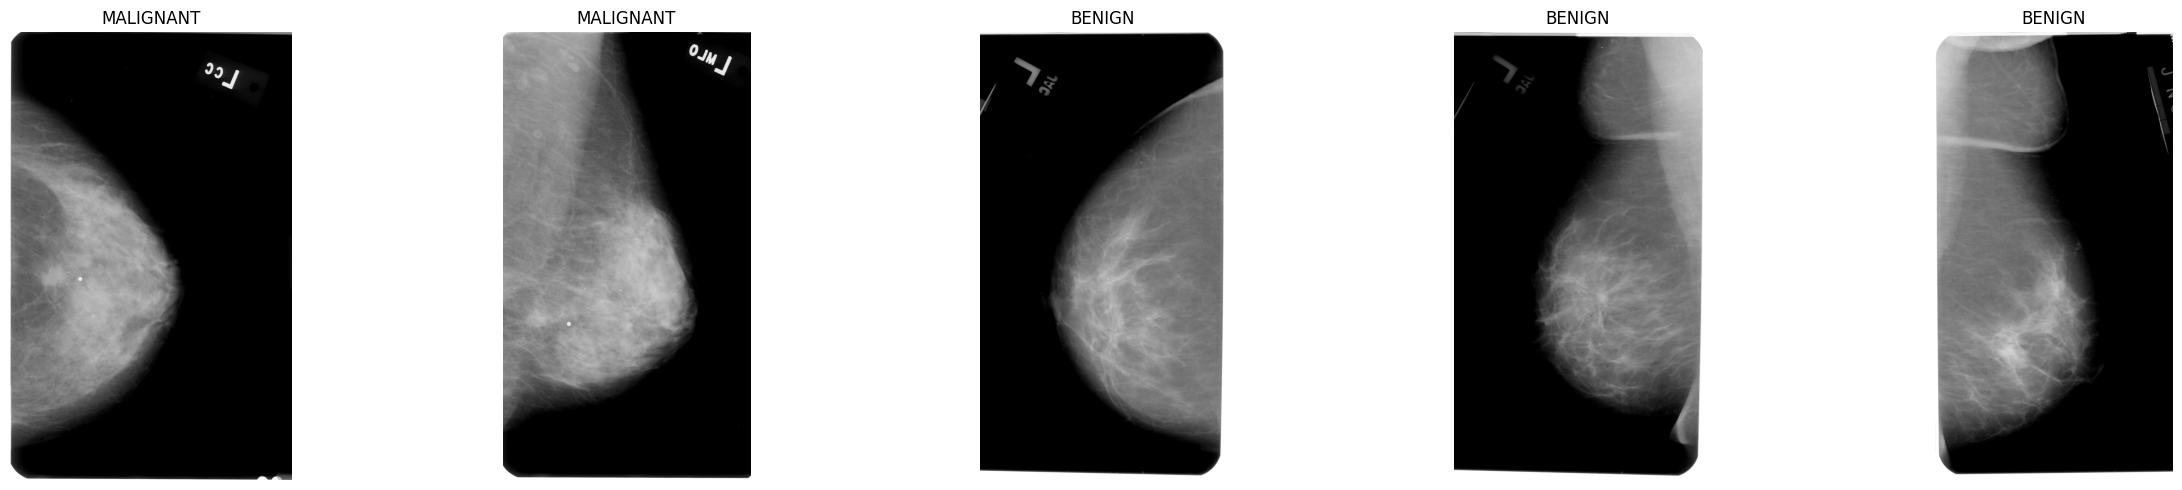

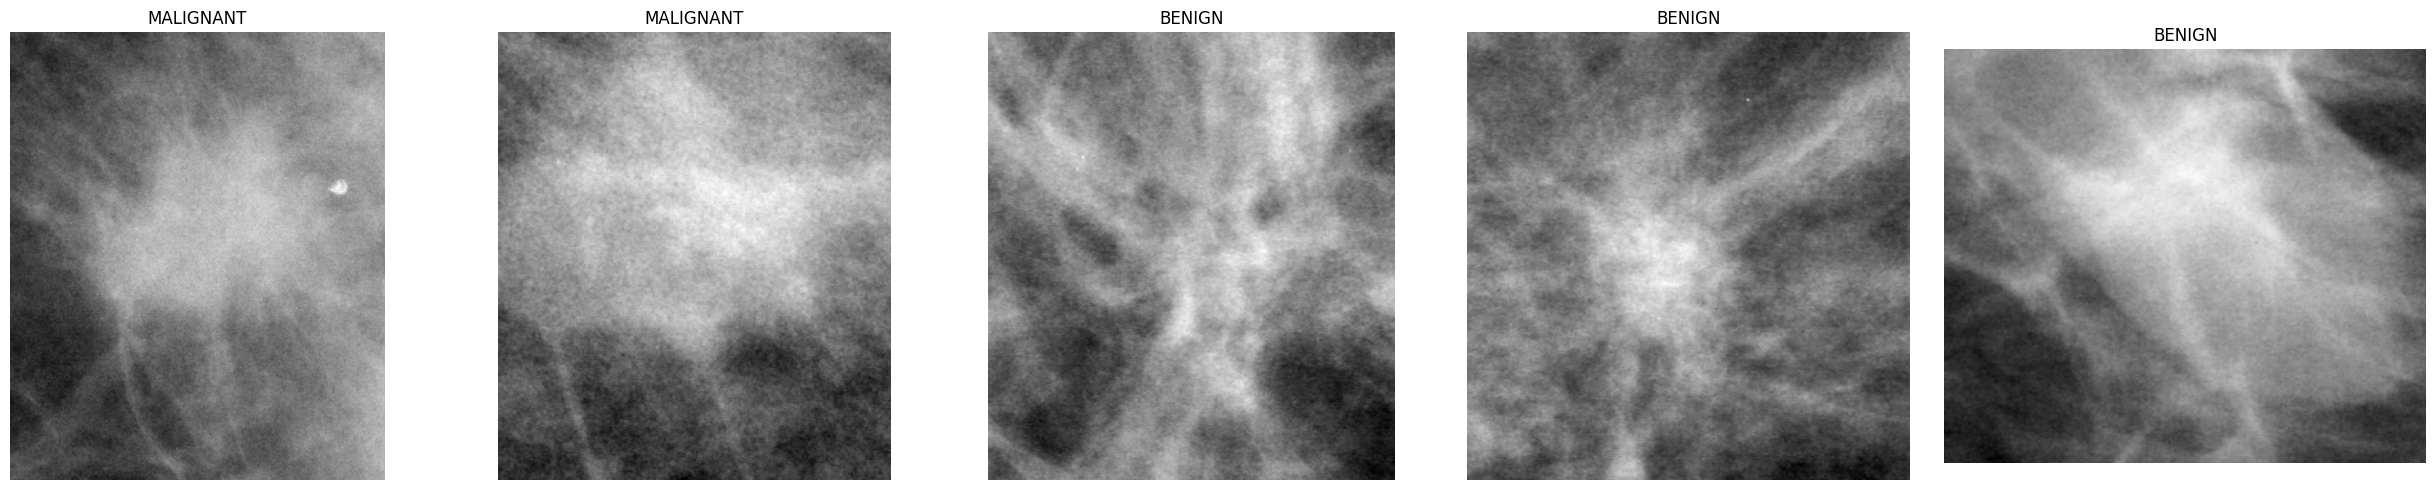

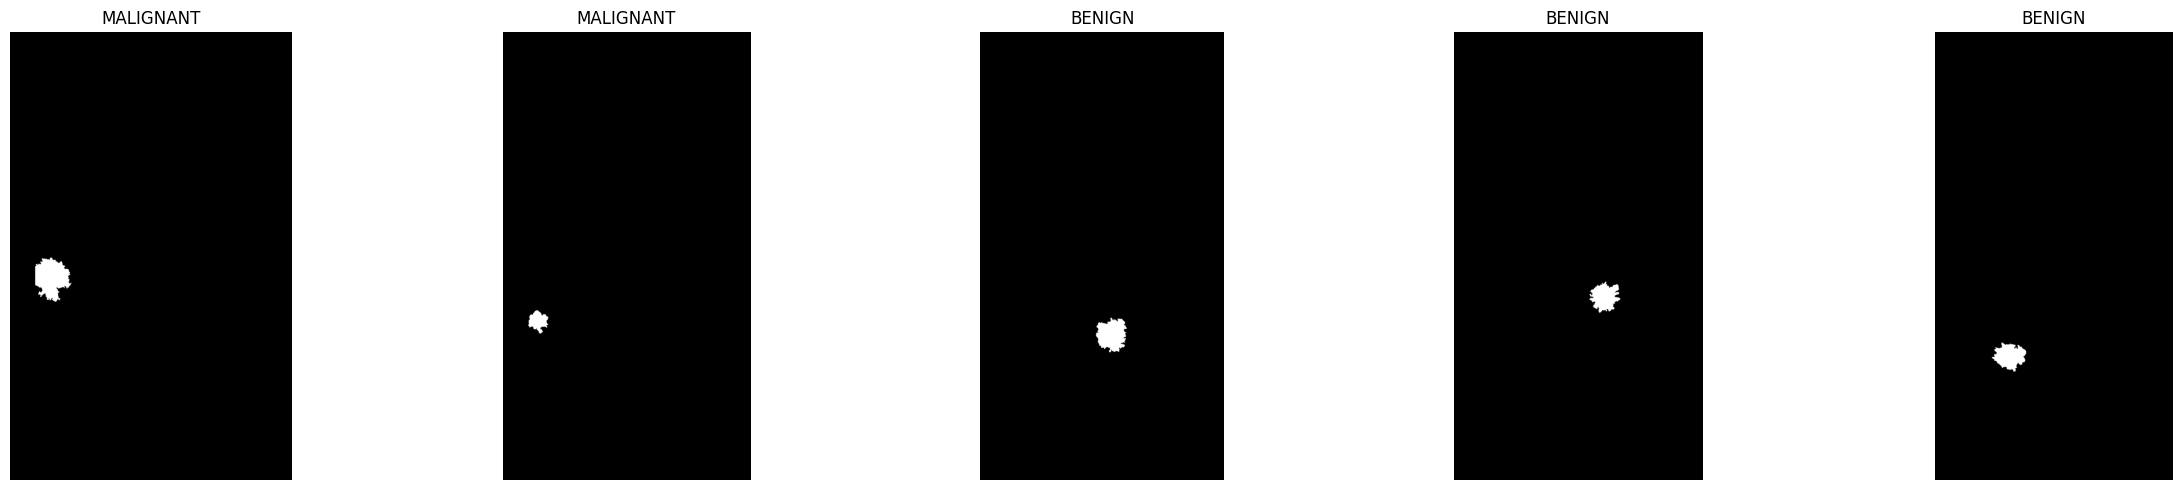

In [25]:
# Show 5 raw full-mammogram images
display_images(mass_train, 'image_file_path', number=5)

# Show 5 cropped images
display_images(mass_train, 'cropped_image_file_path', number=5)

# Show 5 ROI masks
display_images(mass_train, 'ROI_mask_file_path', number=5)


In [27]:
import pandas as pd

# 1a) Combine all four sets
full_df = pd.concat([mass_train, mass_test, calc_train, calc_test], axis=0).reset_index(drop=True)

# 1b) Create a numeric label column
class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0}
full_df['label'] = full_df['pathology'].map(class_mapper)

# 1c) Quick sanity-check
print(full_df.shape)
print(full_df['label'].value_counts())

(3568, 18)
label
0    2111
1    1457
Name: count, dtype: int64


In [28]:
from sklearn.model_selection import train_test_split

# 80/10/10 split (stratified by label)
train_val, test_df  = train_test_split(full_df, test_size=0.10,
                                       stratify=full_df['label'], random_state=42)
train_df, valid_df  = train_test_split(train_val, test_size=0.11,
                                       stratify=train_val['label'], random_state=42)
# 0.11 of 0.9 ≈ 0.10 overall

print("Train:", train_df.shape, "Valid:", valid_df.shape, "Test:", test_df.shape)
print(train_df['label'].value_counts(), valid_df['label'].value_counts(), test_df['label'].value_counts())

Train: (2857, 18) Valid: (354, 18) Test: (357, 18)
label
0    1691
1    1166
Name: count, dtype: int64 label
0    209
1    145
Name: count, dtype: int64 label
0    211
1    146
Name: count, dtype: int64


In [29]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

# 3a) Define your transforms
mean, std = [0.48145466, 0.4578275, 0.40821073], [0.26862954, 0.26130258, 0.27577711]  # CLIP’s default
common_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# 3b) Dataset class
class MammogramDataset(Dataset):
    def __init__(self, df, path_col='image_file_path', label_col='label', transform=None):
        self.df = df.reset_index(drop=True)
        self.path_col = path_col
        self.label_col = label_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img = Image.open(row[self.path_col]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(row[self.label_col], dtype=torch.float32)

# 3c) Instantiate loaders
batch_size = 32
train_ds = MammogramDataset(train_df,    transform=common_tfms)
valid_ds = MammogramDataset(valid_df,    transform=common_tfms)
test_ds  = MammogramDataset(test_df,     transform=common_tfms)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# 4a) Install and import CLIP
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _ = clip.load("ViT-B/32", device=device)
model.eval()

# 4b) Helper to encode a full DataLoader
@torch.no_grad()
def extract_features(dl):
    all_feats, all_labels = [], []
    for imgs, labs in dl:
        imgs = imgs.to(device)
        feats = model.encode_image(imgs)  # shape: (B, 512)
        all_feats.append(feats.cpu())
        all_labels.append(labs)
    return torch.cat(all_feats), torch.cat(all_labels)

train_feats, train_labels = extract_features(train_loader)
valid_feats, valid_labels = extract_features(valid_loader)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-y0isy_gw
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-y0isy_gw
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from torch import nn, optim

classifier = nn.Linear(train_feats.shape[1], 1).to(device)
criterion  = nn.BCEWithLogitsLoss()
optimizer  = optim.Adam(classifier.parameters(), lr=1e-4)

# 5a) One epoch example
def train_epoch():
    classifier.train()
    total_loss = 0
    for feats, labs in zip(train_feats.split(batch_size), train_labels.split(batch_size)):
        feats, labs = feats.to(device), labs.to(device).unsqueeze(1)
        preds = classifier(feats)
        loss  = criterion(preds, labs)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_feats)

# 5b) Validation
def eval_epoch(feats, labs):
    classifier.eval()
    with torch.no_grad():
        logits = classifier(feats.to(device))
        preds  = torch.sigmoid(logits).cpu().numpy() > 0.5
    from sklearn.metrics import accuracy_score
    return accuracy_score(labs.numpy(), preds)

for epoch in range(5):
    loss = train_epoch()
    acc  = eval_epoch(valid_feats, valid_labels)
    print(f"Epoch {epoch+1} — loss: {loss:.4f}, valid acc: {acc:.4f}")

In [ ]:
# Evaluate on test set
test_feats, test_labels = extract_features(test_loader)
test_acc = eval_epoch(test_feats, test_labels)
print("Test accuracy:", test_acc)